In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'native','im':'t1','fe':['b25'],'fi':['t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [2048,1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_2048_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_md_data_norm_b25_t1_mask_t1_native_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 934)
(631390, 1)
validation
(74368, 934)
(74368, 1)
test
(85358, 934)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 934)]             0         


 dense (Dense)               (None, 2048)              1914880   


 dense_1 (Dense)             (None, 1024)              2098176   


 dense_2 (Dense)             (None, 512)               524800    


 dense_3 (Dense)             (None, 256)               131328    


 dense_4 (Dense)             (None, 128)               32896     


 dense_5 (Dense)             (None, 1)                 129       


Total params: 4702209 (17.94 MB)


Trainable params: 4702209 (17.94 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/64 [..............................] - ETA: 2:13 - loss: 0.0788 - STD: 6.4706e-05 - MAE: 0.2705

 3/64 [>.............................] - ETA: 2s - loss: 0.0374 - STD: 6.5818e-05 - MAE: 0.1472  

 5/64 [=>............................] - ETA: 2s - loss: 0.0345 - STD: 4.6625e-05 - MAE: 0.1406

 7/64 [==>...........................] - ETA: 2s - loss: 0.0331 - STD: 3.6492e-05 - MAE: 0.1378

 9/64 [===>..........................] - ETA: 2s - loss: 0.0308 - STD: 3.0803e-05 - MAE: 0.1300

11/64 [====>.........................] - ETA: 2s - loss: 0.0281 - STD: 2.7041e-05 - MAE: 0.1185

13/64 [=====>........................] - ETA: 2s - loss: 0.0258 - STD: 2.4128e-05 - MAE: 0.1128

15/64 [======>.......................] - ETA: 2s - loss: 0.0246 - STD: 2.1704e-05 - MAE: 0.1127

17/64 [======>.......................] - ETA: 2s - loss: 0.0237 - STD: 1.9769e-05 - MAE: 0.1129

19/64 [=======>......................] - ETA: 1s - loss: 0.0227 - STD: 1.8296e-05 - MAE: 0.1107

21/64 [========>.....................] - ETA: 1s - loss: 0.0217 - STD: 1.7132e-05 - MAE: 0.1068

23/64 [=========>....................] - ETA: 1s - loss: 0.0210 - STD: 1.6166e-05 - MAE: 0.1028

25/64 [==========>...................] - ETA: 1s - loss: 0.0205 - STD: 1.5347e-05 - MAE: 0.0995

27/64 [===========>..................] - ETA: 1s - loss: 0.0201 - STD: 1.4654e-05 - MAE: 0.0966

29/64 [============>.................] - ETA: 1s - loss: 0.0195 - STD: 1.4070e-05 - MAE: 0.0940

31/64 [=============>................] - ETA: 1s - loss: 0.0191 - STD: 1.3589e-05 - MAE: 0.0924

33/64 [==============>...............] - ETA: 1s - loss: 0.0187 - STD: 1.3185e-05 - MAE: 0.0916

35/64 [===============>..............] - ETA: 1s - loss: 0.0184 - STD: 1.2841e-05 - MAE: 0.0912

37/64 [================>.............] - ETA: 1s - loss: 0.0181 - STD: 1.2545e-05 - MAE: 0.0907

39/64 [=================>............] - ETA: 1s - loss: 0.0178 - STD: 1.2294e-05 - MAE: 0.0900

41/64 [==================>...........] - ETA: 0s - loss: 0.0176 - STD: 1.2072e-05 - MAE: 0.0889

43/64 [===================>..........] - ETA: 0s - loss: 0.0174 - STD: 1.1879e-05 - MAE: 0.0877

45/64 [====================>.........] - ETA: 0s - loss: 0.0172 - STD: 1.1719e-05 - MAE: 0.0867

47/64 [=====================>........] - ETA: 0s - loss: 0.0170 - STD: 1.1590e-05 - MAE: 0.0858

49/64 [=====================>........] - ETA: 0s - loss: 0.0169 - STD: 1.1485e-05 - MAE: 0.0850

51/64 [======================>.......] - ETA: 0s - loss: 0.0167 - STD: 1.1412e-05 - MAE: 0.0845

53/64 [=======================>......] - ETA: 0s - loss: 0.0166 - STD: 1.1369e-05 - MAE: 0.0841

55/64 [========================>.....] - ETA: 0s - loss: 0.0164 - STD: 1.1345e-05 - MAE: 0.0838

57/64 [=========================>....] - ETA: 0s - loss: 0.0163 - STD: 1.1338e-05 - MAE: 0.0834

59/64 [==========================>...] - ETA: 0s - loss: 0.0162 - STD: 1.1348e-05 - MAE: 0.0829

61/64 [===========================>..] - ETA: 0s - loss: 0.0161 - STD: 1.1373e-05 - MAE: 0.0824

63/64 [============================>.] - ETA: 0s - loss: 0.0159 - STD: 1.1417e-05 - MAE: 0.0819

64/64 [==============================] - 7s 70ms/step - loss: 0.0159 - STD: 1.1445e-05 - MAE: 0.0817 - val_loss: 0.0168 - val_STD: 1.0004e-05 - val_MAE: 0.0779


Epoch 2/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0129 - STD: 1.3635e-05 - MAE: 0.0690

 3/64 [>.............................] - ETA: 2s - loss: 0.0128 - STD: 1.3992e-05 - MAE: 0.0697

 5/64 [=>............................] - ETA: 2s - loss: 0.0127 - STD: 1.4392e-05 - MAE: 0.0705

 7/64 [==>...........................] - ETA: 2s - loss: 0.0127 - STD: 1.4799e-05 - MAE: 0.0709

 9/64 [===>..........................] - ETA: 2s - loss: 0.0126 - STD: 1.5207e-05 - MAE: 0.0709

11/64 [====>.........................] - ETA: 2s - loss: 0.0127 - STD: 1.5627e-05 - MAE: 0.0708

13/64 [=====>........................] - ETA: 2s - loss: 0.0127 - STD: 1.6062e-05 - MAE: 0.0705

15/64 [======>.......................] - ETA: 2s - loss: 0.0127 - STD: 1.6515e-05 - MAE: 0.0702

17/64 [======>.......................] - ETA: 2s - loss: 0.0127 - STD: 1.6995e-05 - MAE: 0.0702

19/64 [=======>......................] - ETA: 1s - loss: 0.0127 - STD: 1.7517e-05 - MAE: 0.0702

21/64 [========>.....................] - ETA: 1s - loss: 0.0128 - STD: 1.8063e-05 - MAE: 0.0703

23/64 [=========>....................] - ETA: 1s - loss: 0.0128 - STD: 1.8633e-05 - MAE: 0.0705

25/64 [==========>...................] - ETA: 1s - loss: 0.0128 - STD: 1.9229e-05 - MAE: 0.0706

27/64 [===========>..................] - ETA: 1s - loss: 0.0128 - STD: 1.9867e-05 - MAE: 0.0705

29/64 [============>.................] - ETA: 1s - loss: 0.0128 - STD: 2.0517e-05 - MAE: 0.0705

31/64 [=============>................] - ETA: 1s - loss: 0.0128 - STD: 2.1209e-05 - MAE: 0.0705

33/64 [==============>...............] - ETA: 1s - loss: 0.0128 - STD: 2.1931e-05 - MAE: 0.0705

35/64 [===============>..............] - ETA: 1s - loss: 0.0128 - STD: 2.2702e-05 - MAE: 0.0705

37/64 [================>.............] - ETA: 1s - loss: 0.0128 - STD: 2.3528e-05 - MAE: 0.0705

39/64 [=================>............] - ETA: 1s - loss: 0.0128 - STD: 2.4392e-05 - MAE: 0.0705

41/64 [==================>...........] - ETA: 0s - loss: 0.0127 - STD: 2.5293e-05 - MAE: 0.0704

43/64 [===================>..........] - ETA: 0s - loss: 0.0127 - STD: 2.6249e-05 - MAE: 0.0704

45/64 [====================>.........] - ETA: 0s - loss: 0.0127 - STD: 2.7279e-05 - MAE: 0.0704

47/64 [=====================>........] - ETA: 0s - loss: 0.0127 - STD: 2.8360e-05 - MAE: 0.0703

49/64 [=====================>........] - ETA: 0s - loss: 0.0127 - STD: 2.9534e-05 - MAE: 0.0703

51/64 [======================>.......] - ETA: 0s - loss: 0.0127 - STD: 3.0782e-05 - MAE: 0.0702

53/64 [=======================>......] - ETA: 0s - loss: 0.0127 - STD: 3.2133e-05 - MAE: 0.0702

55/64 [========================>.....] - ETA: 0s - loss: 0.0127 - STD: 3.3584e-05 - MAE: 0.0703

57/64 [=========================>....] - ETA: 0s - loss: 0.0127 - STD: 3.5137e-05 - MAE: 0.0703

59/64 [==========================>...] - ETA: 0s - loss: 0.0127 - STD: 3.6794e-05 - MAE: 0.0703

61/64 [===========================>..] - ETA: 0s - loss: 0.0127 - STD: 3.8611e-05 - MAE: 0.0703

63/64 [============================>.] - ETA: 0s - loss: 0.0127 - STD: 4.0557e-05 - MAE: 0.0702

64/64 [==============================] - 3s 47ms/step - loss: 0.0127 - STD: 4.1572e-05 - MAE: 0.0702 - val_loss: 0.0168 - val_STD: 8.1523e-05 - val_MAE: 0.0790


Epoch 3/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0127 - STD: 1.1121e-04 - MAE: 0.0700

 3/64 [>.............................] - ETA: 2s - loss: 0.0127 - STD: 1.1725e-04 - MAE: 0.0698

 5/64 [=>............................] - ETA: 2s - loss: 0.0126 - STD: 1.2316e-04 - MAE: 0.0696

 7/64 [==>...........................] - ETA: 2s - loss: 0.0126 - STD: 1.2956e-04 - MAE: 0.0696

 9/64 [===>..........................] - ETA: 2s - loss: 0.0126 - STD: 1.3668e-04 - MAE: 0.0697

11/64 [====>.........................] - ETA: 2s - loss: 0.0127 - STD: 1.4456e-04 - MAE: 0.0700

13/64 [=====>........................] - ETA: 2s - loss: 0.0127 - STD: 1.5304e-04 - MAE: 0.0700

15/64 [======>.......................] - ETA: 2s - loss: 0.0127 - STD: 1.6270e-04 - MAE: 0.0701

17/64 [======>.......................] - ETA: 2s - loss: 0.0127 - STD: 1.7345e-04 - MAE: 0.0702

19/64 [=======>......................] - ETA: 1s - loss: 0.0127 - STD: 1.8533e-04 - MAE: 0.0702

21/64 [========>.....................] - ETA: 1s - loss: 0.0127 - STD: 1.9893e-04 - MAE: 0.0702

23/64 [=========>....................] - ETA: 1s - loss: 0.0127 - STD: 2.1413e-04 - MAE: 0.0701

25/64 [==========>...................] - ETA: 1s - loss: 0.0127 - STD: 2.3174e-04 - MAE: 0.0701

27/64 [===========>..................] - ETA: 1s - loss: 0.0127 - STD: 2.5157e-04 - MAE: 0.0701

29/64 [============>.................] - ETA: 1s - loss: 0.0127 - STD: 2.7470e-04 - MAE: 0.0701

31/64 [=============>................] - ETA: 1s - loss: 0.0127 - STD: 3.0165e-04 - MAE: 0.0700

33/64 [==============>...............] - ETA: 1s - loss: 0.0127 - STD: 3.3351e-04 - MAE: 0.0701

35/64 [===============>..............] - ETA: 1s - loss: 0.0127 - STD: 3.7076e-04 - MAE: 0.0701

37/64 [================>.............] - ETA: 1s - loss: 0.0127 - STD: 4.1509e-04 - MAE: 0.0700

39/64 [=================>............] - ETA: 1s - loss: 0.0127 - STD: 4.6864e-04 - MAE: 0.0701

41/64 [==================>...........] - ETA: 1s - loss: 0.0127 - STD: 5.3301e-04 - MAE: 0.0700

43/64 [===================>..........] - ETA: 0s - loss: 0.0127 - STD: 6.1229e-04 - MAE: 0.0700

45/64 [====================>.........] - ETA: 0s - loss: 0.0127 - STD: 7.1183e-04 - MAE: 0.0700

47/64 [=====================>........] - ETA: 0s - loss: 0.0126 - STD: 8.3564e-04 - MAE: 0.0700

49/64 [=====================>........] - ETA: 0s - loss: 0.0126 - STD: 9.8922e-04 - MAE: 0.0699

51/64 [======================>.......] - ETA: 0s - loss: 0.0126 - STD: 0.0012 - MAE: 0.0697    

53/64 [=======================>......] - ETA: 0s - loss: 0.0125 - STD: 0.0014 - MAE: 0.0695

55/64 [========================>.....] - ETA: 0s - loss: 0.0125 - STD: 0.0017 - MAE: 0.0693

57/64 [=========================>....] - ETA: 0s - loss: 0.0124 - STD: 0.0021 - MAE: 0.0691

59/64 [==========================>...] - ETA: 0s - loss: 0.0123 - STD: 0.0026 - MAE: 0.0688

61/64 [===========================>..] - ETA: 0s - loss: 0.0122 - STD: 0.0032 - MAE: 0.0685

63/64 [============================>.] - ETA: 0s - loss: 0.0121 - STD: 0.0040 - MAE: 0.0682

64/64 [==============================] - 3s 47ms/step - loss: 0.0121 - STD: 0.0045 - MAE: 0.0679 - val_loss: 0.0107 - val_STD: 0.0267 - val_MAE: 0.0617


Epoch 4/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0075 - STD: 0.0355 - MAE: 0.0518

 3/64 [>.............................] - ETA: 2s - loss: 0.0073 - STD: 0.0398 - MAE: 0.0509

 5/64 [=>............................] - ETA: 2s - loss: 0.0069 - STD: 0.0446 - MAE: 0.0499

 7/64 [==>...........................] - ETA: 2s - loss: 0.0065 - STD: 0.0489 - MAE: 0.0483

 9/64 [===>..........................] - ETA: 2s - loss: 0.0061 - STD: 0.0534 - MAE: 0.0469

11/64 [====>.........................] - ETA: 2s - loss: 0.0058 - STD: 0.0577 - MAE: 0.0458

13/64 [=====>........................] - ETA: 2s - loss: 0.0055 - STD: 0.0618 - MAE: 0.0447

15/64 [======>.......................] - ETA: 2s - loss: 0.0052 - STD: 0.0653 - MAE: 0.0438

17/64 [======>.......................] - ETA: 2s - loss: 0.0050 - STD: 0.0679 - MAE: 0.0430

19/64 [=======>......................] - ETA: 1s - loss: 0.0049 - STD: 0.0709 - MAE: 0.0424

21/64 [========>.....................] - ETA: 1s - loss: 0.0047 - STD: 0.0730 - MAE: 0.0418

23/64 [=========>....................] - ETA: 1s - loss: 0.0046 - STD: 0.0748 - MAE: 0.0413

25/64 [==========>...................] - ETA: 1s - loss: 0.0044 - STD: 0.0769 - MAE: 0.0409

27/64 [===========>..................] - ETA: 1s - loss: 0.0043 - STD: 0.0785 - MAE: 0.0405

29/64 [============>.................] - ETA: 1s - loss: 0.0043 - STD: 0.0798 - MAE: 0.0401

31/64 [=============>................] - ETA: 1s - loss: 0.0042 - STD: 0.0814 - MAE: 0.0397

33/64 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0823 - MAE: 0.0394

35/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0832 - MAE: 0.0391

37/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0842 - MAE: 0.0388

39/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0848 - MAE: 0.0386

41/64 [==================>...........] - ETA: 0s - loss: 0.0038 - STD: 0.0857 - MAE: 0.0383

43/64 [===================>..........] - ETA: 0s - loss: 0.0038 - STD: 0.0866 - MAE: 0.0381

45/64 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0868 - MAE: 0.0379

47/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0875 - MAE: 0.0377

49/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0882 - MAE: 0.0376

51/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0886 - MAE: 0.0374

53/64 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0890 - MAE: 0.0372

55/64 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0894 - MAE: 0.0370

57/64 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0899 - MAE: 0.0369

59/64 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0901 - MAE: 0.0367

61/64 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0904 - MAE: 0.0366

63/64 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0910 - MAE: 0.0364

64/64 [==============================] - 3s 47ms/step - loss: 0.0033 - STD: 0.0910 - MAE: 0.0363 - val_loss: 0.0025 - val_STD: 0.0780 - val_MAE: 0.0337


Epoch 5/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0021 - STD: 0.0914 - MAE: 0.0308

 3/64 [>.............................] - ETA: 2s - loss: 0.0021 - STD: 0.0972 - MAE: 0.0310

 5/64 [=>............................] - ETA: 2s - loss: 0.0021 - STD: 0.1006 - MAE: 0.0310

 7/64 [==>...........................] - ETA: 2s - loss: 0.0021 - STD: 0.1008 - MAE: 0.0310

 9/64 [===>..........................] - ETA: 2s - loss: 0.0021 - STD: 0.1006 - MAE: 0.0309

11/64 [====>.........................] - ETA: 2s - loss: 0.0021 - STD: 0.1005 - MAE: 0.0308

13/64 [=====>........................] - ETA: 2s - loss: 0.0021 - STD: 0.1011 - MAE: 0.0308

15/64 [======>.......................] - ETA: 2s - loss: 0.0021 - STD: 0.1012 - MAE: 0.0307

17/64 [======>.......................] - ETA: 2s - loss: 0.0021 - STD: 0.1011 - MAE: 0.0306

19/64 [=======>......................] - ETA: 1s - loss: 0.0020 - STD: 0.1014 - MAE: 0.0305

21/64 [========>.....................] - ETA: 1s - loss: 0.0020 - STD: 0.1018 - MAE: 0.0304

23/64 [=========>....................] - ETA: 1s - loss: 0.0020 - STD: 0.1016 - MAE: 0.0304

25/64 [==========>...................] - ETA: 1s - loss: 0.0020 - STD: 0.1015 - MAE: 0.0304

27/64 [===========>..................] - ETA: 1s - loss: 0.0020 - STD: 0.1018 - MAE: 0.0303

29/64 [============>.................] - ETA: 1s - loss: 0.0020 - STD: 0.1021 - MAE: 0.0303

31/64 [=============>................] - ETA: 1s - loss: 0.0020 - STD: 0.1019 - MAE: 0.0303

33/64 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.1019 - MAE: 0.0302

35/64 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.1022 - MAE: 0.0302

37/64 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1024 - MAE: 0.0303

39/64 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1023 - MAE: 0.0303

41/64 [==================>...........] - ETA: 0s - loss: 0.0020 - STD: 0.1023 - MAE: 0.0303

43/64 [===================>..........] - ETA: 0s - loss: 0.0020 - STD: 0.1025 - MAE: 0.0302

45/64 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.1024 - MAE: 0.0302

47/64 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.1024 - MAE: 0.0302

49/64 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.1026 - MAE: 0.0301

51/64 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.1026 - MAE: 0.0301

53/64 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1025 - MAE: 0.0300

55/64 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1025 - MAE: 0.0300

57/64 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1026 - MAE: 0.0299

59/64 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1026 - MAE: 0.0299

61/64 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1025 - MAE: 0.0299

63/64 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1026 - MAE: 0.0298

64/64 [==============================] - 3s 47ms/step - loss: 0.0019 - STD: 0.1025 - MAE: 0.0298 - val_loss: 0.0024 - val_STD: 0.0975 - val_MAE: 0.0331


Epoch 6/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0019 - STD: 0.1075 - MAE: 0.0295

 3/64 [>.............................] - ETA: 2s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0294

 5/64 [=>............................] - ETA: 2s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0294

 7/64 [==>...........................] - ETA: 2s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0291

 9/64 [===>..........................] - ETA: 2s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0290

11/64 [====>.........................] - ETA: 2s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0289

13/64 [=====>........................] - ETA: 2s - loss: 0.0018 - STD: 0.1036 - MAE: 0.0288

15/64 [======>.......................] - ETA: 1s - loss: 0.0018 - STD: 0.1034 - MAE: 0.0288

17/64 [======>.......................] - ETA: 1s - loss: 0.0018 - STD: 0.1031 - MAE: 0.0288

19/64 [=======>......................] - ETA: 1s - loss: 0.0018 - STD: 0.1036 - MAE: 0.0288

21/64 [========>.....................] - ETA: 1s - loss: 0.0018 - STD: 0.1037 - MAE: 0.0287

23/64 [=========>....................] - ETA: 1s - loss: 0.0018 - STD: 0.1036 - MAE: 0.0287

25/64 [==========>...................] - ETA: 1s - loss: 0.0018 - STD: 0.1037 - MAE: 0.0286

27/64 [===========>..................] - ETA: 1s - loss: 0.0018 - STD: 0.1037 - MAE: 0.0286

29/64 [============>.................] - ETA: 1s - loss: 0.0018 - STD: 0.1037 - MAE: 0.0285

31/64 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.1037 - MAE: 0.0285

33/64 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0285

35/64 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0285

37/64 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0285

39/64 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0285

41/64 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0286

43/64 [===================>..........] - ETA: 0s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0286

45/64 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0286

47/64 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0286

49/64 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0286

51/64 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0286

53/64 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0286

55/64 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0285

57/64 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0286

59/64 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0285

61/64 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0285

63/64 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0285

64/64 [==============================] - 3s 47ms/step - loss: 0.0018 - STD: 0.1040 - MAE: 0.0285 - val_loss: 0.0017 - val_STD: 0.0923 - val_MAE: 0.0288


Epoch 7/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.1029 - MAE: 0.0283

 3/64 [>.............................] - ETA: 2s - loss: 0.0017 - STD: 0.1054 - MAE: 0.0278

 5/64 [=>............................] - ETA: 2s - loss: 0.0017 - STD: 0.1037 - MAE: 0.0277

 7/64 [==>...........................] - ETA: 2s - loss: 0.0017 - STD: 0.1036 - MAE: 0.0277

 9/64 [===>..........................] - ETA: 2s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0277

11/64 [====>.........................] - ETA: 2s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0277

13/64 [=====>........................] - ETA: 2s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0277

15/64 [======>.......................] - ETA: 2s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0277

17/64 [======>.......................] - ETA: 2s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0278

19/64 [=======>......................] - ETA: 1s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0278

21/64 [========>.....................] - ETA: 1s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0278

23/64 [=========>....................] - ETA: 1s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0278

25/64 [==========>...................] - ETA: 1s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0279

27/64 [===========>..................] - ETA: 1s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0280

29/64 [============>.................] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0279

31/64 [=============>................] - ETA: 1s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0279

33/64 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0279

35/64 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0280

37/64 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0280

39/64 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0280

41/64 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0279

43/64 [===================>..........] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0279

45/64 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0279

47/64 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0279

49/64 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0279

51/64 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0279

53/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0279

55/64 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0278

57/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0278

59/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0278

61/64 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0278

63/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0278

64/64 [==============================] - 3s 46ms/step - loss: 0.0017 - STD: 0.1044 - MAE: 0.0278 - val_loss: 0.0019 - val_STD: 0.0959 - val_MAE: 0.0296


Epoch 8/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.1088 - MAE: 0.0274

 3/64 [>.............................] - ETA: 2s - loss: 0.0016 - STD: 0.1040 - MAE: 0.0274

 5/64 [=>............................] - ETA: 2s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0276

 7/64 [==>...........................] - ETA: 2s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0275

 9/64 [===>..........................] - ETA: 2s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

11/64 [====>.........................] - ETA: 2s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0272

13/64 [=====>........................] - ETA: 2s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0272

15/64 [======>.......................] - ETA: 2s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0271

17/64 [======>.......................] - ETA: 2s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0271

19/64 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0271

21/64 [========>.....................] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0271

23/64 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0272

25/64 [==========>...................] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0276

27/64 [===========>..................] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0276

29/64 [============>.................] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0280

31/64 [=============>................] - ETA: 1s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0280

33/64 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0282

35/64 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0288

37/64 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0293

39/64 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1036 - MAE: 0.0297

41/64 [==================>...........] - ETA: 0s - loss: 0.0019 - STD: 0.1043 - MAE: 0.0299

43/64 [===================>..........] - ETA: 0s - loss: 0.0019 - STD: 0.1035 - MAE: 0.0301

45/64 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1040 - MAE: 0.0302

47/64 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1035 - MAE: 0.0302

49/64 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1038 - MAE: 0.0302

51/64 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1038 - MAE: 0.0302

53/64 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1036 - MAE: 0.0302

55/64 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1037 - MAE: 0.0302

57/64 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0301

59/64 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1036 - MAE: 0.0301

61/64 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1036 - MAE: 0.0300

63/64 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1035 - MAE: 0.0300

64/64 [==============================] - 3s 46ms/step - loss: 0.0019 - STD: 0.1035 - MAE: 0.0300 - val_loss: 0.0019 - val_STD: 0.0890 - val_MAE: 0.0299


Epoch 9/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.1033 - MAE: 0.0277

 3/64 [>.............................] - ETA: 2s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0280

 5/64 [=>............................] - ETA: 2s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0280

 7/64 [==>...........................] - ETA: 2s - loss: 0.0017 - STD: 0.1035 - MAE: 0.0279

 9/64 [===>..........................] - ETA: 2s - loss: 0.0017 - STD: 0.1037 - MAE: 0.0280

11/64 [====>.........................] - ETA: 2s - loss: 0.0017 - STD: 0.1035 - MAE: 0.0279

13/64 [=====>........................] - ETA: 2s - loss: 0.0016 - STD: 0.1036 - MAE: 0.0278

15/64 [======>.......................] - ETA: 2s - loss: 0.0017 - STD: 0.1038 - MAE: 0.0277

17/64 [======>.......................] - ETA: 2s - loss: 0.0016 - STD: 0.1036 - MAE: 0.0277

19/64 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1037 - MAE: 0.0277

21/64 [========>.....................] - ETA: 1s - loss: 0.0016 - STD: 0.1038 - MAE: 0.0276

23/64 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.1040 - MAE: 0.0276

25/64 [==========>...................] - ETA: 1s - loss: 0.0016 - STD: 0.1038 - MAE: 0.0276

27/64 [===========>..................] - ETA: 1s - loss: 0.0016 - STD: 0.1041 - MAE: 0.0275

29/64 [============>.................] - ETA: 1s - loss: 0.0016 - STD: 0.1041 - MAE: 0.0275

31/64 [=============>................] - ETA: 1s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0275

33/64 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0274

35/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0274

37/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0273

39/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0273

41/64 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0273

43/64 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0273

45/64 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0273

47/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0272

49/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0272

51/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0272

53/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0272

55/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0272

57/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0271

59/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0271

61/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0271

63/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0271

64/64 [==============================] - 3s 46ms/step - loss: 0.0016 - STD: 0.1044 - MAE: 0.0271 - val_loss: 0.0017 - val_STD: 0.0958 - val_MAE: 0.0288


Epoch 10/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.1029 - MAE: 0.0268

 3/64 [>.............................] - ETA: 2s - loss: 0.0015 - STD: 0.1041 - MAE: 0.0267

 5/64 [=>............................] - ETA: 2s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0266

 7/64 [==>...........................] - ETA: 2s - loss: 0.0015 - STD: 0.1044 - MAE: 0.0267

 9/64 [===>..........................] - ETA: 2s - loss: 0.0015 - STD: 0.1042 - MAE: 0.0266

11/64 [====>.........................] - ETA: 2s - loss: 0.0015 - STD: 0.1044 - MAE: 0.0266

13/64 [=====>........................] - ETA: 2s - loss: 0.0015 - STD: 0.1045 - MAE: 0.0266

15/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1046 - MAE: 0.0266

17/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1046 - MAE: 0.0266

19/64 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1044 - MAE: 0.0266

21/64 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1045 - MAE: 0.0266

23/64 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0266

25/64 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0267

27/64 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0267

29/64 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1046 - MAE: 0.0266

31/64 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1047 - MAE: 0.0266

33/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0266

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0266

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0266

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266

41/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

43/64 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

45/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

47/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

64/64 [==============================] - 3s 47ms/step - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266 - val_loss: 0.0018 - val_STD: 0.0973 - val_MAE: 0.0296


Epoch 11/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0015 - STD: 0.1068 - MAE: 0.0264

 3/64 [>.............................] - ETA: 2s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0266

 5/64 [=>............................] - ETA: 2s - loss: 0.0016 - STD: 0.1066 - MAE: 0.0270

 7/64 [==>...........................] - ETA: 2s - loss: 0.0015 - STD: 0.1074 - MAE: 0.0268

 9/64 [===>..........................] - ETA: 2s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0267

11/64 [====>.........................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0266

13/64 [=====>........................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

15/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0265

17/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

19/64 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

21/64 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0265

23/64 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0265

25/64 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

27/64 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

29/64 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

31/64 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

33/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

41/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

43/64 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

45/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

47/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

64/64 [==============================] - 3s 46ms/step - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264 - val_loss: 0.0019 - val_STD: 0.0994 - val_MAE: 0.0299


Epoch 12/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1090 - MAE: 0.0268

 3/64 [>.............................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0268

 5/64 [=>............................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

 7/64 [==>...........................] - ETA: 2s - loss: 0.0015 - STD: 0.1066 - MAE: 0.0266

 9/64 [===>..........................] - ETA: 2s - loss: 0.0015 - STD: 0.1066 - MAE: 0.0264

11/64 [====>.........................] - ETA: 2s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0264

13/64 [=====>........................] - ETA: 2s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0264

15/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1065 - MAE: 0.0264

17/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0264

19/64 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0264

21/64 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0264

23/64 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0265

25/64 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0264

27/64 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0264

29/64 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0264

31/64 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0264

33/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0265

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0265

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

41/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

43/64 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

45/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

47/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

64/64 [==============================] - 3s 47ms/step - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264 - val_loss: 0.0015 - val_STD: 0.0951 - val_MAE: 0.0271


Epoch 13/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0262

 3/64 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1039 - MAE: 0.0261

 5/64 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0261

 7/64 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0260

 9/64 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0260

11/64 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

13/64 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0261

15/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0261

17/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

19/64 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

21/64 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0264

23/64 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0265

25/64 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

27/64 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

29/64 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

31/64 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

33/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

41/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

43/64 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

45/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

47/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

64/64 [==============================] - 3s 46ms/step - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265 - val_loss: 0.0020 - val_STD: 0.0991 - val_MAE: 0.0307


Epoch 14/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1075 - MAE: 0.0265

 3/64 [>.............................] - ETA: 2s - loss: 0.0016 - STD: 0.1063 - MAE: 0.0279

 5/64 [=>............................] - ETA: 2s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0272

 7/64 [==>...........................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0269

 9/64 [===>..........................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

11/64 [====>.........................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

13/64 [=====>........................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

15/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

17/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

19/64 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

21/64 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

23/64 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0262

25/64 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0262

27/64 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0262

29/64 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

31/64 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

33/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

41/64 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

43/64 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

45/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

47/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0262

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0263

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

64/64 [==============================] - 3s 46ms/step - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263 - val_loss: 0.0020 - val_STD: 0.0987 - val_MAE: 0.0307


Epoch 15/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1108 - MAE: 0.0267

 3/64 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1078 - MAE: 0.0262

 5/64 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1089 - MAE: 0.0259

 7/64 [==>...........................] - ETA: 2s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0263

 9/64 [===>..........................] - ETA: 2s - loss: 0.0015 - STD: 0.1075 - MAE: 0.0263

11/64 [====>.........................] - ETA: 2s - loss: 0.0015 - STD: 0.1069 - MAE: 0.0265

13/64 [=====>........................] - ETA: 2s - loss: 0.0015 - STD: 0.1072 - MAE: 0.0265

15/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1065 - MAE: 0.0268

17/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0267

19/64 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1065 - MAE: 0.0267

21/64 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1065 - MAE: 0.0266

23/64 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0266

25/64 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0265

27/64 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0265

29/64 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0265

31/64 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0266

33/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0266

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0266

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0266

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0266

41/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0266

43/64 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0266

45/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0265

47/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0265

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0265

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0263

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0263

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

64/64 [==============================] - 3s 47ms/step - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263 - val_loss: 0.0015 - val_STD: 0.0945 - val_MAE: 0.0268


Epoch 16/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0259

 3/64 [>.............................] - ETA: 2s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0269

 5/64 [=>............................] - ETA: 2s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0265

 7/64 [==>...........................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0262

 9/64 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0261

11/64 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0260

13/64 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0260

15/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0262

17/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0263

19/64 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0262

21/64 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0263

23/64 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0263

25/64 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0263

27/64 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0263

29/64 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0263

31/64 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0263

33/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0262

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0262

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0262

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0262

41/64 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0261

43/64 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0261

45/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0262

47/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

64/64 [==============================] - 3s 46ms/step - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265 - val_loss: 0.0015 - val_STD: 0.0938 - val_MAE: 0.0271


Epoch 17/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0259

 3/64 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0255

 5/64 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0255

 7/64 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0256

 9/64 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

11/64 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

13/64 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

15/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

17/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

19/64 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

21/64 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

23/64 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257

25/64 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

27/64 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

29/64 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0257

31/64 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0258

33/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

41/64 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

43/64 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

45/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

47/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0258

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0258

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0258

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

64/64 [==============================] - 3s 47ms/step - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258 - val_loss: 0.0015 - val_STD: 0.0953 - val_MAE: 0.0266


Epoch 18/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0266

 3/64 [>.............................] - ETA: 2s - loss: 0.0015 - STD: 0.1066 - MAE: 0.0263

 5/64 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0262

 7/64 [==>...........................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

 9/64 [===>..........................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

11/64 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0262

13/64 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0261

15/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

17/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

19/64 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

21/64 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0258

23/64 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0258

25/64 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0257

27/64 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0258

29/64 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0258

31/64 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0258

33/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0258

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0258

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0258

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0258

41/64 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

43/64 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

45/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

47/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

64/64 [==============================] - 3s 46ms/step - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257 - val_loss: 0.0018 - val_STD: 0.0988 - val_MAE: 0.0288


Epoch 19/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0013 - STD: 0.1077 - MAE: 0.0255

 3/64 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1083 - MAE: 0.0257

 5/64 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

 7/64 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0257

 9/64 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257

11/64 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0256

13/64 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

15/64 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257

17/64 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0259

19/64 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0259

21/64 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0259

23/64 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

25/64 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

27/64 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0258

29/64 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

31/64 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

33/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

41/64 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

43/64 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

45/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0257

47/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

64/64 [==============================] - 3s 46ms/step - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256 - val_loss: 0.0017 - val_STD: 0.0970 - val_MAE: 0.0280


Epoch 20/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0013 - STD: 0.1037 - MAE: 0.0252

 3/64 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0252

 5/64 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0253

 7/64 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0254

 9/64 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

11/64 [====>.........................] - ETA: 2s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0264

13/64 [=====>........................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

15/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0263

17/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0263

19/64 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0262

21/64 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

23/64 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262

25/64 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262

27/64 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262

29/64 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0262

31/64 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

33/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

41/64 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

43/64 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

45/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

47/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

64/64 [==============================] - 3s 46ms/step - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258 - val_loss: 0.0016 - val_STD: 0.0978 - val_MAE: 0.0274


Epoch 21/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0256

 3/64 [>.............................] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0253

 5/64 [=>............................] - ETA: 2s - loss: 0.0013 - STD: 0.1050 - MAE: 0.0251

 7/64 [==>...........................] - ETA: 2s - loss: 0.0013 - STD: 0.1051 - MAE: 0.0252

 9/64 [===>..........................] - ETA: 2s - loss: 0.0013 - STD: 0.1056 - MAE: 0.0253

11/64 [====>.........................] - ETA: 2s - loss: 0.0013 - STD: 0.1055 - MAE: 0.0253

13/64 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

15/64 [======>.......................] - ETA: 2s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0253

17/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0254

19/64 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0253

21/64 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0254

23/64 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0255

25/64 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

27/64 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

29/64 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

31/64 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0256

33/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0256

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

41/64 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

43/64 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

45/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

47/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0257

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0257

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0257

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0257

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0258

64/64 [==============================] - 3s 46ms/step - loss: 0.0014 - STD: 0.1062 - MAE: 0.0258 - val_loss: 0.0019 - val_STD: 0.0981 - val_MAE: 0.0298


Epoch 22/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

 3/64 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0256

 5/64 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0257

 7/64 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0256

 9/64 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0255

11/64 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0255

13/64 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

15/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

17/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

19/64 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0255

21/64 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

23/64 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

25/64 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

27/64 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0255

29/64 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0255

31/64 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0256

33/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0256

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0256

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0256

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0256

41/64 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0256

43/64 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

45/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

47/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0257

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0257

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

64/64 [==============================] - 3s 47ms/step - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257 - val_loss: 0.0014 - val_STD: 0.0921 - val_MAE: 0.0260


Epoch 23/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.0995 - MAE: 0.0267

 3/64 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0262

 5/64 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0258

 7/64 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0259

 9/64 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0258

11/64 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0258

13/64 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0259

15/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1071 - MAE: 0.0258

17/64 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0257

19/64 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0258

21/64 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1071 - MAE: 0.0258

23/64 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0258

25/64 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0258

27/64 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0257

29/64 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0257

31/64 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0257

33/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0257

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0256

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0256

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0256

41/64 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

43/64 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

45/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

47/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0255

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0255

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0255

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0255

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

64/64 [==============================] - 3s 46ms/step - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255 - val_loss: 0.0014 - val_STD: 0.0951 - val_MAE: 0.0262


Epoch 24/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0013 - STD: 0.1029 - MAE: 0.0252

 3/64 [>.............................] - ETA: 2s - loss: 0.0013 - STD: 0.1055 - MAE: 0.0251

 5/64 [=>............................] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0253

 7/64 [==>...........................] - ETA: 2s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0252

 9/64 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0256

11/64 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0255

13/64 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0255

15/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0255

17/64 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

19/64 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0255

21/64 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0257

23/64 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0257

25/64 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0258

27/64 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

29/64 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

31/64 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0258

33/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0258

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0257

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

41/64 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0257

43/64 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0257

45/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

47/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

64/64 [==============================] - 3s 46ms/step - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255 - val_loss: 0.0014 - val_STD: 0.0951 - val_MAE: 0.0262


Epoch 25/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0013 - STD: 0.1006 - MAE: 0.0249

 3/64 [>.............................] - ETA: 2s - loss: 0.0013 - STD: 0.1035 - MAE: 0.0248

 5/64 [=>............................] - ETA: 2s - loss: 0.0013 - STD: 0.1057 - MAE: 0.0252

 7/64 [==>...........................] - ETA: 2s - loss: 0.0013 - STD: 0.1053 - MAE: 0.0251

 9/64 [===>..........................] - ETA: 2s - loss: 0.0013 - STD: 0.1057 - MAE: 0.0252

11/64 [====>.........................] - ETA: 2s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0252

13/64 [=====>........................] - ETA: 2s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0252

15/64 [======>.......................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0252

17/64 [======>.......................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0252

19/64 [=======>......................] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0252

21/64 [========>.....................] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0252

23/64 [=========>....................] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0252

25/64 [==========>...................] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0252

27/64 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

29/64 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

31/64 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0254

33/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

41/64 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

43/64 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

45/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

47/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

64/64 [==============================] - 3s 46ms/step - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254 - val_loss: 0.0020 - val_STD: 0.1005 - val_MAE: 0.0296


Epoch 26/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0014 - STD: 0.1074 - MAE: 0.0255

 3/64 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1075 - MAE: 0.0259

 5/64 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0255

 7/64 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0260

 9/64 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1070 - MAE: 0.0258

11/64 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0257

13/64 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0257

15/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0256

17/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0256

19/64 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0256

21/64 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0256

23/64 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

25/64 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0257

27/64 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0257

29/64 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0256

31/64 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

33/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0256

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0256

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

41/64 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

43/64 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0255

45/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

47/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

64/64 [==============================] - 3s 46ms/step - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255 - val_loss: 0.0016 - val_STD: 0.1003 - val_MAE: 0.0272


Epoch 27/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1044 - MAE: 0.0256

 3/64 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1050 - MAE: 0.0253

 5/64 [=>............................] - ETA: 2s - loss: 0.0013 - STD: 0.1052 - MAE: 0.0251

 7/64 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0254

 9/64 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

11/64 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

13/64 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

15/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0254

17/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0255

19/64 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0254

21/64 [========>.....................] - ETA: 1s - loss: 0.0013 - STD: 0.1057 - MAE: 0.0253

23/64 [=========>....................] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0253

25/64 [==========>...................] - ETA: 1s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0253

27/64 [===========>..................] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0253

29/64 [============>.................] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0252

31/64 [=============>................] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0252

33/64 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0252

35/64 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0252

37/64 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

39/64 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

41/64 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

43/64 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

45/64 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0252

47/64 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0252

49/64 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0252

51/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0252

53/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0252

55/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0252

57/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0253

59/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0253

61/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0253

63/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0253

64/64 [==============================] - 3s 46ms/step - loss: 0.0013 - STD: 0.1064 - MAE: 0.0253 - val_loss: 0.0016 - val_STD: 0.0980 - val_MAE: 0.0271


Epoch 28/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0012 - STD: 0.1045 - MAE: 0.0242

 3/64 [>.............................] - ETA: 1s - loss: 0.0013 - STD: 0.1041 - MAE: 0.0249

 5/64 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

 7/64 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1047 - MAE: 0.0259

 9/64 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0262

11/64 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0262

13/64 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

15/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

17/64 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

19/64 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

21/64 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

23/64 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0258

25/64 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0258

27/64 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

29/64 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

31/64 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

33/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

41/64 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

43/64 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

45/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

47/64 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0253

49/64 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0253

51/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0253

53/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0253

55/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0253

57/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0253

59/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0252

61/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0252

63/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0252

64/64 [==============================] - 3s 46ms/step - loss: 0.0013 - STD: 0.1063 - MAE: 0.0252 - val_loss: 0.0014 - val_STD: 0.0965 - val_MAE: 0.0260


Epoch 29/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1047 - MAE: 0.0260

 3/64 [>.............................] - ETA: 2s - loss: 0.0013 - STD: 0.1056 - MAE: 0.0252

 5/64 [=>............................] - ETA: 2s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0250

 7/64 [==>...........................] - ETA: 2s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0252

 9/64 [===>..........................] - ETA: 2s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0252

11/64 [====>.........................] - ETA: 2s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0253

13/64 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0253

15/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

17/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0255

19/64 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0255

21/64 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0255

23/64 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

25/64 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

27/64 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

29/64 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

31/64 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

33/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

41/64 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

43/64 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

45/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

47/64 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0253

49/64 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0253

51/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0253

53/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0253

55/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0252

57/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0252

59/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0252

61/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0252

63/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0252

64/64 [==============================] - 3s 46ms/step - loss: 0.0013 - STD: 0.1063 - MAE: 0.0252 - val_loss: 0.0019 - val_STD: 0.1016 - val_MAE: 0.0286


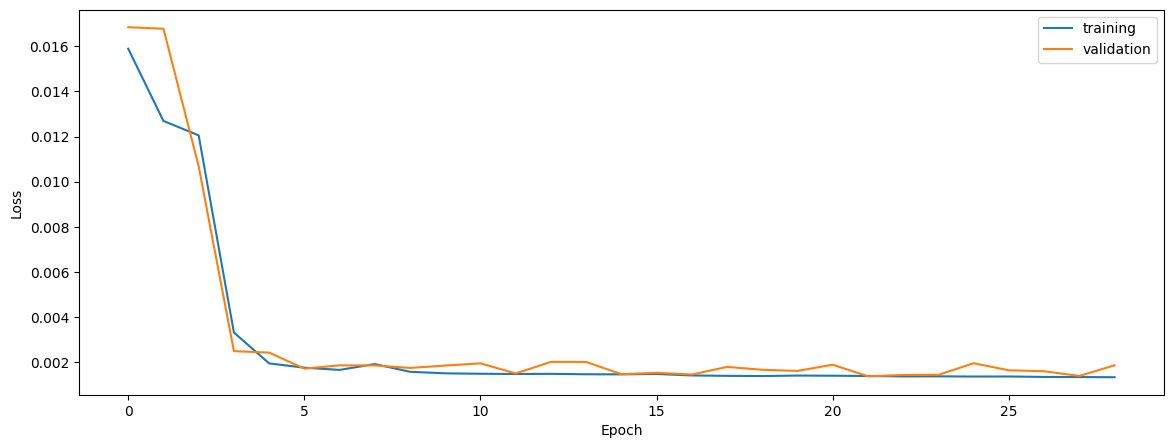

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.9456830722370914
0.9580484748026413
0.9509911359257802


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.9463133623216748
0.954792519155698
0.9521984838476736


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.952840950332723
0.9565272757519493
0.9636468536717248


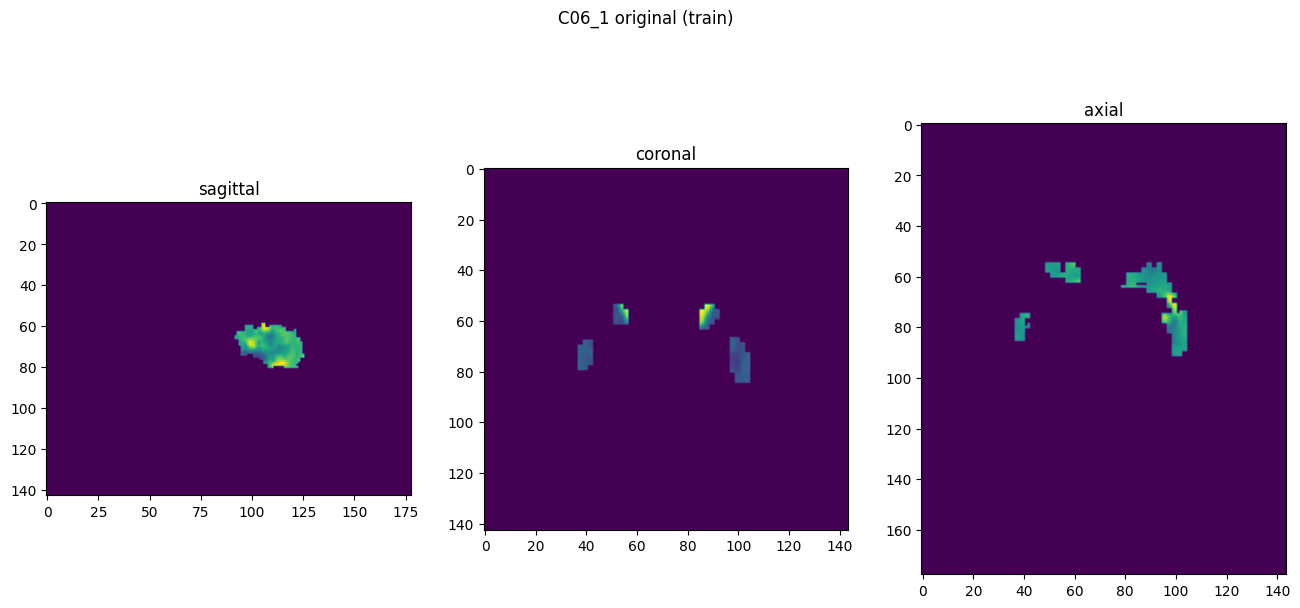

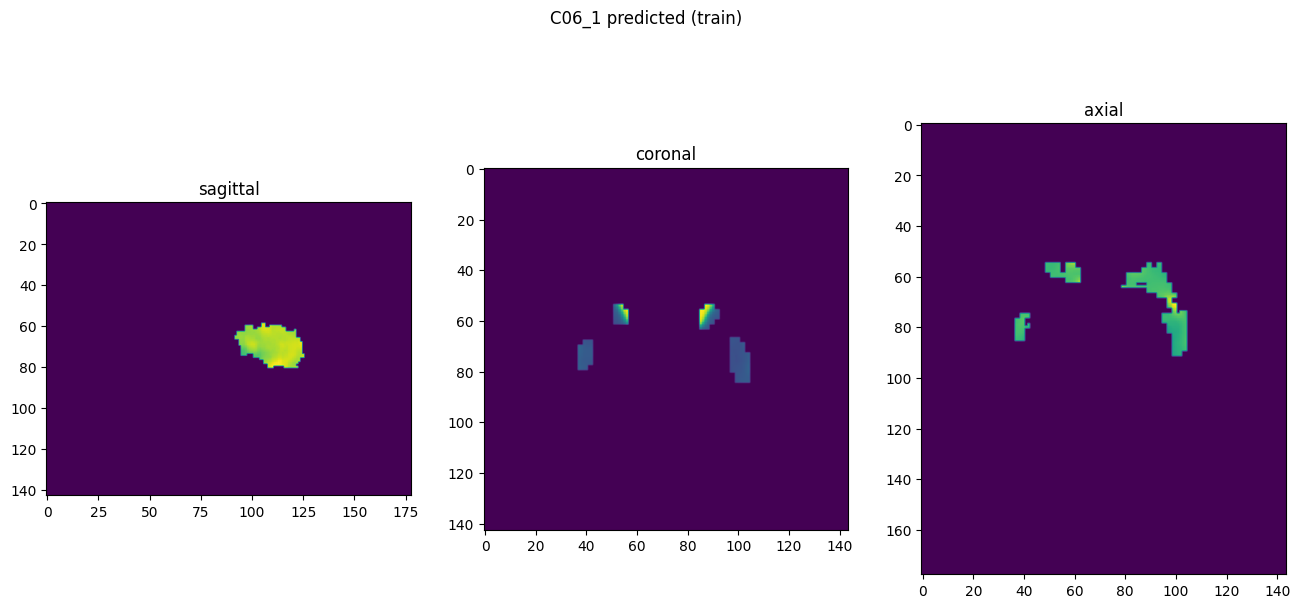

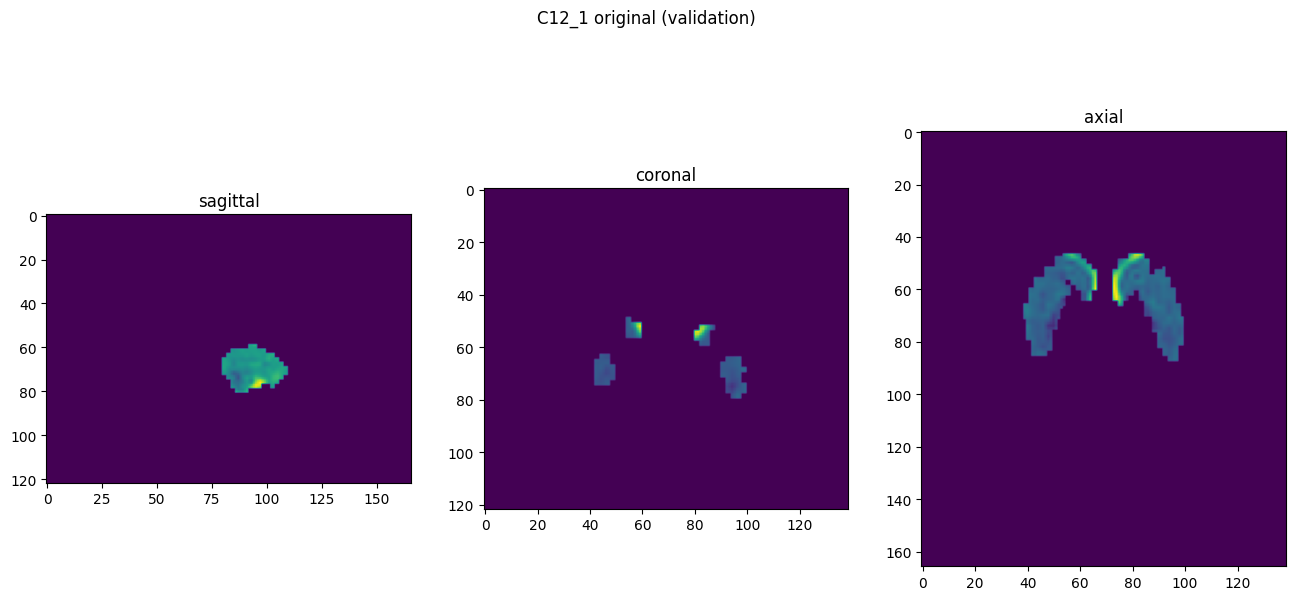

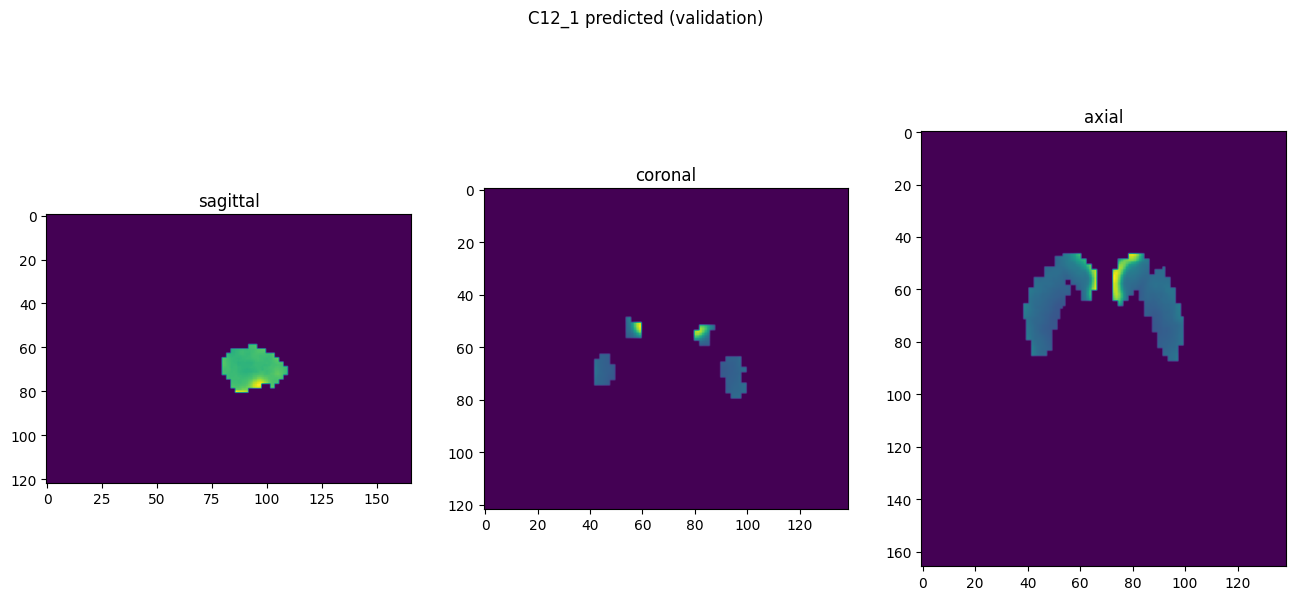

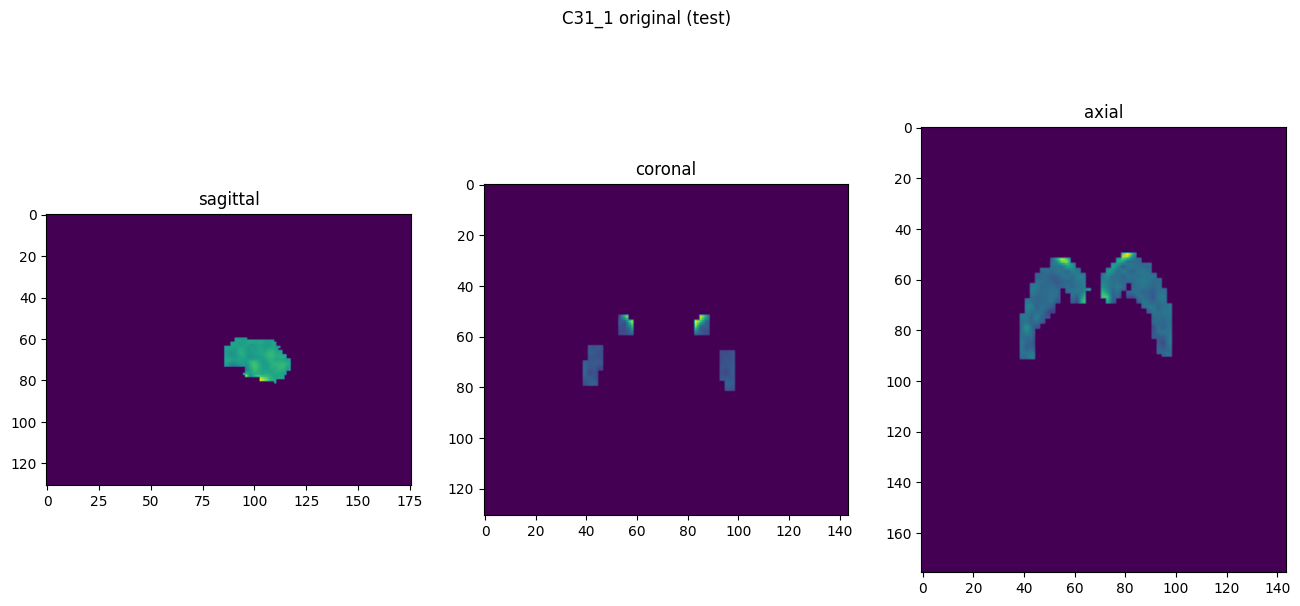

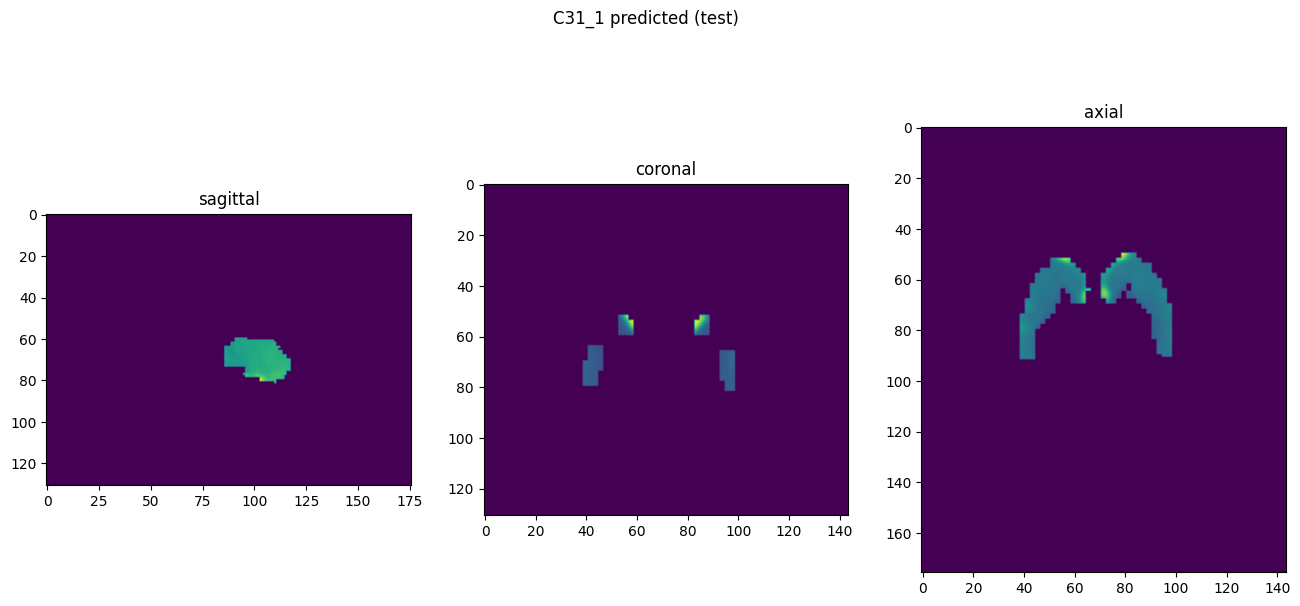

In [10]:
showResults(model, gen, threshold=None, background=False)